In [1]:
import pandas as pd
import numpy as np
import time
import math
from scipy import stats

data = pd.read_excel('gasstationdata33.xlsx')
data.describe()

,Unnamed: 0,Customer,Arrival Time,Service time Fuel,Shop time,Service time payment
count,421.000000,421.000000,421,421.000000,421.000000,421.000000
mean,210.000000,210.000000,2024-02-01 14:05:36.790508032,289.990499,15.712589,45.660333
min,0.000000,0.000000,2024-02-01 06:00:06.644000,47.000000,0.000000,35.000000
25%,105.000000,105.000000,2024-02-01 09:55:41.463000064,179.000000,0.000000,41.000000
50%,210.000000,210.000000,2024-02-01 14:15:47.782000128,272.000000,0.000000,46.000000
75%,315.000000,315.000000,2024-02-01 17:57:28.728000,364.000000,0.000000,51.000000
max,420.000000,420.000000,2024-02-01 21:59:00.876000,925.000000,444.000000,55.000000
std,121.676484,121.676484,NaN,150.114036,44.506934,5.628251


__Preprocessing the data__

In [2]:
# convert data into a dataframe
data = pd.DataFrame(data, columns = data.columns)
# data["Interarrival Times"] = interarrival_times

data = data.drop(columns = ["Unnamed: 0"])

list_of_attributes = ["Service time Fuel", "Shop time", "Service time payment", "Interarrival Times"]
data.head()

,Customer,Arrival Time,Parking Preference,Service time Fuel,Shop time,Service time payment
0,0,2024-02-01 06:00:06.644,NaN,181,0,46
1,1,2024-02-01 06:03:05.847,Left,158,29,38
2,2,2024-02-01 06:05:45.348,NaN,357,0,39
3,3,2024-02-01 06:07:31.426,Right,802,0,37
4,4,2024-02-01 06:15:28.037,Right,359,0,50


In [3]:
# Convert timestamps to datetime objects
arrivals_datetime = [arrival.to_pydatetime() for arrival in data["Arrival Time"]]

start_time = pd.to_datetime('2024-02-01 06:00:00')

# Calculate interarrival times in minutes
interarrival_times = [(arrivals_datetime[i] - arrivals_datetime[i-1]).total_seconds()  if i != 0 else 
                      (arrivals_datetime[0] - start_time).total_seconds() for i in range(len(arrivals_datetime))]

data["Interarrival Times"] = interarrival_times

In [4]:
# data converted into minutes
for attribute in list_of_attributes:
    data[attribute] = data[attribute] / 60

data.head()

,Customer,Arrival Time,Parking Preference,Service time Fuel,Shop time,Service time payment,Interarrival Times
0,0,2024-02-01 06:00:06.644,NaN,3.016667,0.000000,0.766667,0.110733
1,1,2024-02-01 06:03:05.847,Left,2.633333,0.483333,0.633333,2.986717
2,2,2024-02-01 06:05:45.348,NaN,5.950000,0.000000,0.650000,2.658350
3,3,2024-02-01 06:07:31.426,Right,13.366667,0.000000,0.616667,1.767967
4,4,2024-02-01 06:15:28.037,Right,5.983333,0.000000,0.833333,7.943517


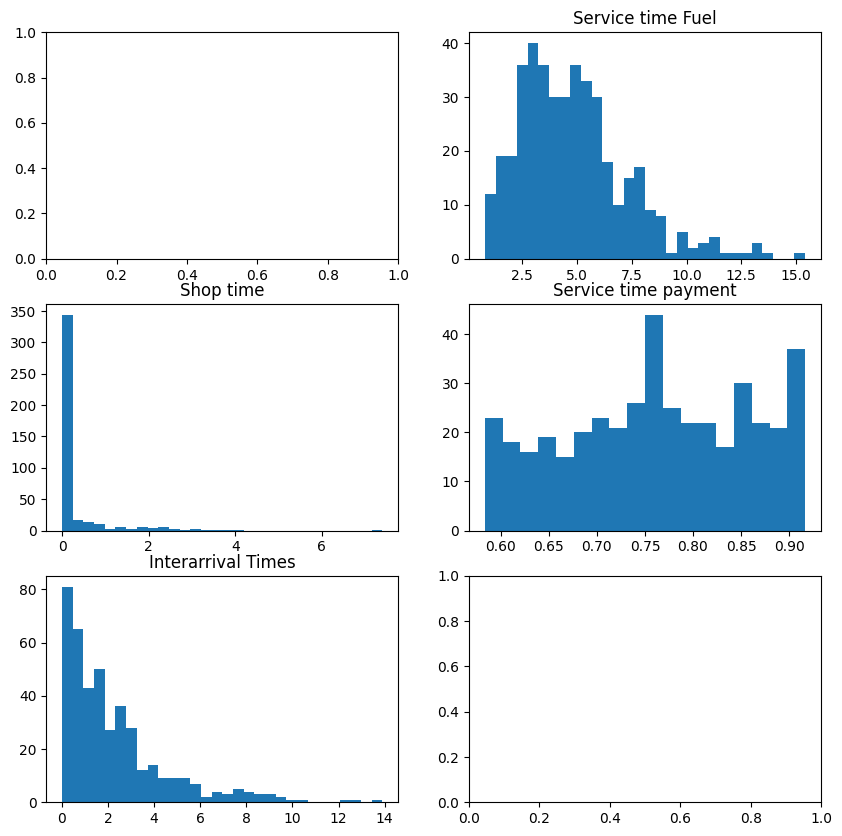

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# axs[0,0].hist(data["Parking Preference"], bins=30)
# axs[0,0].set_title("Parking Preference")

axs[0,1].hist(data["Service time Fuel"], bins=30)
axs[0,1].set_title("Service time Fuel")

axs[1,0].hist(data["Shop time"], bins=30)
axs[1,0].set_title("Shop time")

axs[1,1].hist(data["Service time payment"], bins=18)
axs[1,1].set_title("Service time payment")

axs[2,0].hist(data["Interarrival Times"], bins=30)
axs[2,0].set_title("Interarrival Times")

# axs[0,0].hist(interarrival_times, bins=30)
# axs[1].hist(fuel_time, bins=20)
# axs[2].hist(shop_time, bins= math.floor(np.sqrt(len(shop_time))))
# axs[2].set_xlim(0, 200)

# show the plot
plt.show()

__Testing underlying distributions__

In [6]:
# conver the shop time into a binary variable
shop_time = data["Shop time"]
shop_time = shop_time.apply(lambda x: 1 if x > 0 else 0)

count_1 = shop_time[shop_time == 1].count()
count_0 = shop_time[shop_time == 0].count()

percentage_1 = count_1 / (count_1 + count_0)
percentage_0 = count_0 / (count_1 + count_0)

print (percentage_0, percentage_1)


0.7767220902612827 0.22327790973871733


In [7]:
preference = data["Parking Preference"]

count_right = preference[preference == "Right"].count()
count_left = preference[preference == "Left"].count()
count_non = len(preference) - count_right - count_left

percentage_right = count_right / (count_right + count_left + count_non)
percentage_left = count_left / (count_right + count_left + count_non)
percentage_non = count_non / (count_right + count_left + count_non)

print (percentage_right, percentage_left, percentage_non)

0.07600950118764846 0.09501187648456057 0.828978622327791


In [ ]:
for attribute in list_of_attributes:

    # remove all zeros
    data = data[data[attribute] != 0]
    # remove all nan

    print(f"------------------Testing for {attribute}-------------------")

    # exponential distribution
    M1 = np.mean(data[attribute])
    fitExponentialDist = stats.expon(scale = 1 / M1)
    test = stats.kstest(data[attribute], fitExponentialDist.cdf)
    print("Exponential Distribution")
    print(test)
    if test[1] < 0.05:
        print("Bad fit since p-value is less than 0.05")
    else: 
        print("Good fit since p-value is greater than 0.05")
    
    print("")

    # gamma distribution
    M2 = np.mean([x**2 for x in data[attribute]])
    estBeta = M1 / (M2 - M1**2)
    estAlpha = M1 * estBeta
    fitGammaDist = stats.gamma(a = estAlpha, scale = 1 / estBeta)
    test = stats.kstest(data[attribute], fitGammaDist.cdf)
    print("Gamma Distribution")
    print(test)
    if test[1] < 0.05:
        print("Bad fit since p-value is less than 0.05")
    else: 
        print("Good fit since p-value is greater than 0.05")
    
    print("")

    # poisson distribution
    fiPoissonDist = stats.poisson(mu = M1)
    test = stats.kstest(data[attribute], fiPoissonDist.cdf)
    print("Poisson Distribution")
    print(test)
    if test[1] < 0.05:
        print("Bad fit since p-value is less than 0.05")
    else: 
        print("Good fit since p-value is greater than 0.05")

    print("")

    # normal distribution
    estimated_std = M2 - M1**2
    fitNormalDist = stats.norm(loc = M1, scale = estimated_std)
    test = stats.kstest(data[attribute], fitNormalDist.cdf)
    print("Normal Distribution")
    print(test)
    if test[1] < 0.05:
        print("Bad fit since p-value is less than 0.05")
    else: 
        print("Good fit since p-value is greater than 0.05")

    
    print(f"M1: {M1}")
    print(f"M2: {M2}")
    print(f"Estimated alpha: {estAlpha}")
    print(f"Estimated beta: {estBeta}")
    print(f"Estimated std: {estimated_std}")
    
    print("----------------------------------------------------------")
    print("")

In [ ]:
data.columns

In [ ]:
# SPLOM
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
# axs[0,0].scatter(data["Service time Fuel"], data["Service time Fuel"])
axs[0,0].violinplot(data["Service time Fuel"])

axs[0,1].scatter(data["Service time Fuel"], data["Service time payment"])
axs[0,1].set_xlabel("Service Time Fuel")
axs[0,1].set_ylabel("Service Time Payment")

axs[0,2].scatter(data["Service time Fuel"], data["Shop time"])
axs[0,2].set_xlabel("Service Time Fuel")
axs[0,2].set_ylabel("Shop Time")

axs[0,3].scatter(data["Service time Fuel"], data["Arrival Time (H)"])
axs[0,3].set_xlabel("Service Time Fuel")
axs[0,3].set_ylabel("Arrival Time (H)")



axs[1,0].scatter(data["Service time payment"], data["Service time Fuel"])
axs[1,0].set_xlabel("Service Time Payment")
axs[1,0].set_ylabel("Service Time Fuel")

axs[1,1].violinplot(data["Service time payment"])

axs[1,2].scatter(data["Service time payment"], data["Shop time"])
axs[1,2].set_xlabel("Service Time Payment")
axs[1,2].set_ylabel("Shop Time")


axs[1,3].scatter(data["Service time payment"], data["Arrival Time (H)"])
axs[1,3].set_xlabel("Service Time Payment")
axs[1,3].set_ylabel("Arrival Time (H)")

axs[2,0].scatter(data["Shop time"], data["Service time Fuel"])
axs[2,0].set_xlabel("Shop Time")
axs[2,0].set_ylabel("Service Time Fuel")

axs[2,1].scatter(data["Shop time"], data["Service time payment"])
axs[2,1].set_xlabel("Shop Time")
axs[2,1].set_ylabel("Service Time Payment")

axs[2,2].violinplot( data["Shop time"])

axs[2,3].scatter(data["Shop time"], data["Arrival Time (H)"])
axs[2,3].set_xlabel("Shop Time")
axs[2,3].set_ylabel("Arrival Time (H)")



axs[3,0].scatter(data["Arrival Time (H)"], data["Service time Fuel"])
axs[3,0].set_xlabel("Arrival Time (H)")
axs[3,0].set_ylabel("Service Time Fuel")

axs[3,1].scatter(data["Arrival Time (H)"], data["Service time payment"])
axs[3,1].set_xlabel("Arrival Time (H)")
axs[3,1].set_ylabel("Service Time Payment")



axs[3,2].scatter(data["Arrival Time (H)"], data["Shop time"])
axs[3,2].set_xlabel("Arrival Time (H)")
axs[3,2].set_ylabel("Shop Time")

axs[3,3].hist( data["Arrival Time (H)"])




;

In [ ]:
import plotly.express as px
px.parallel_coordinates(
    data_frame=data,
    dimensions=[
        "Arrival Time (H)",
        "Shop time",
        "Service time Fuel",
        "Service time payment"
    ],
    color="Arrival Time (H)"
)

In [ ]:
# data["Arrival Time"].dt.hour